In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.append("/Users/chernals/cernbox/Work/packages")
sys.path.append("/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines")
import pandas as pd
import numpy as np
import physics
import matplotlib.pyplot as plt

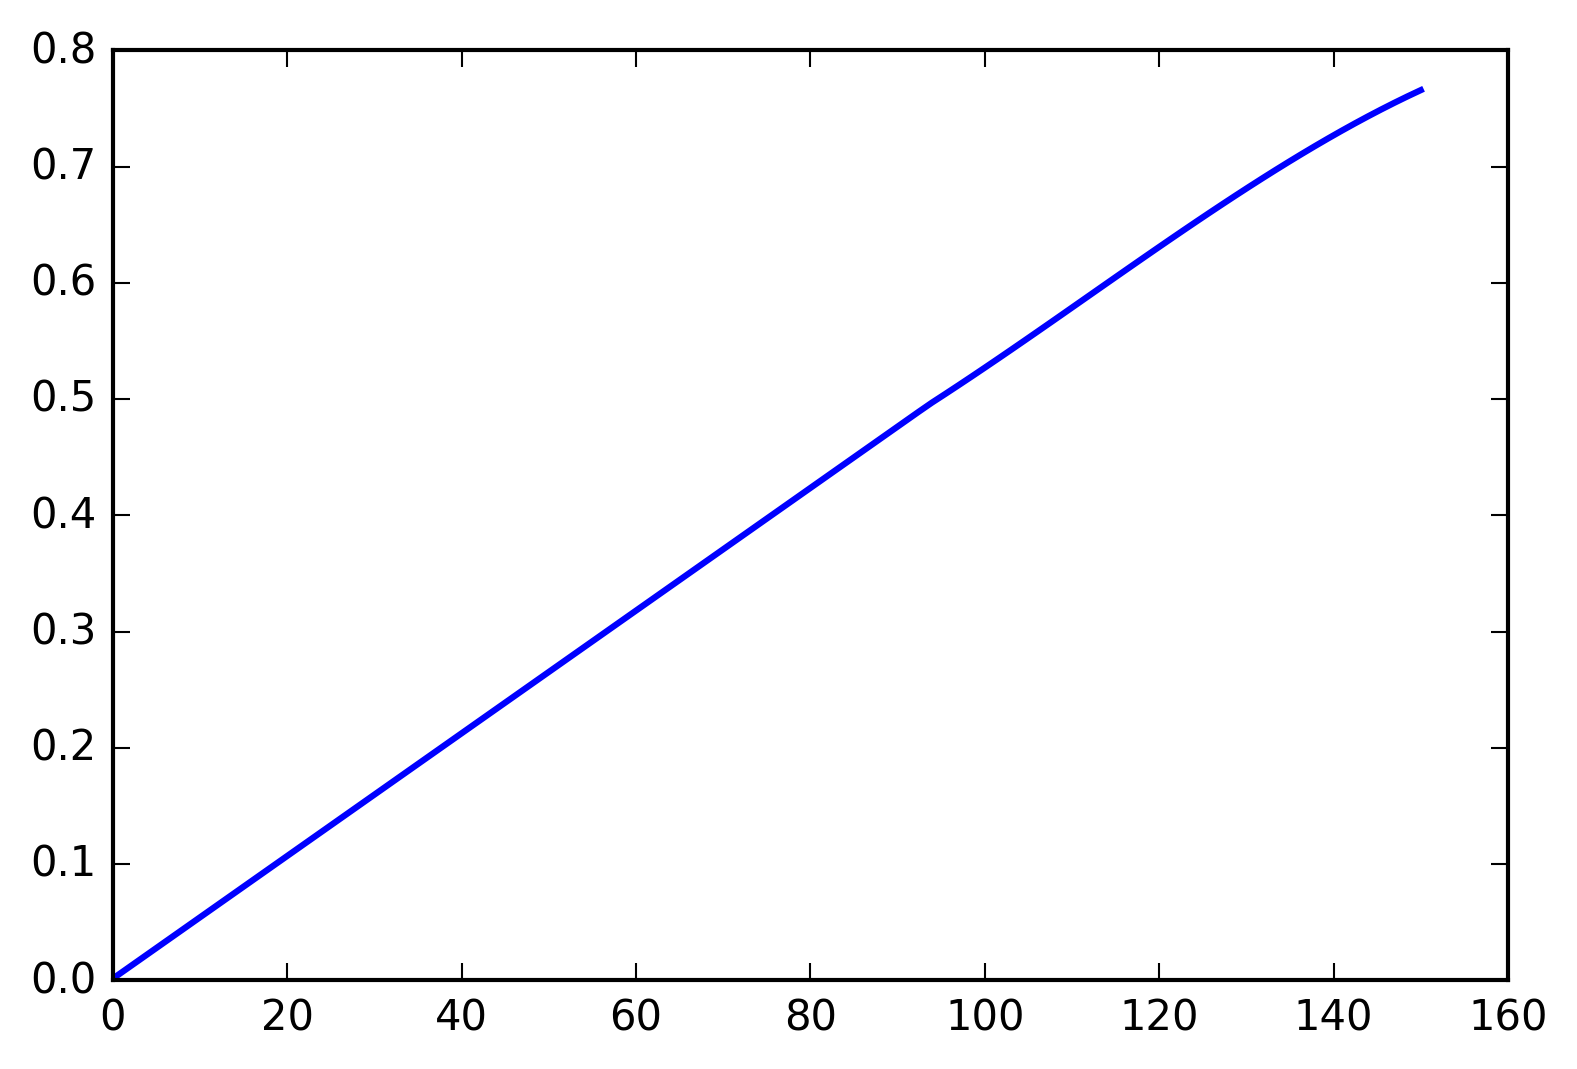

In [2]:
from magnets import *
esbtsquad_current_to_field(10)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.linspace(0, 150, 100), np.vectorize(esbtsquad_current_to_field)(np.linspace(0, 150, 100)))

In [3]:
from georges.physics import *
range_to_energy(30)

217.71573253261019

In [ ]:
s2  =  b 

In [3]:
import physics
physics.get_degrader_divergence(217)*physics.get_degrader_spot_size(217)

11.700000000000001

In [83]:
physics.get_degrader_spot_size(217)**2

0.81

In [96]:
physics.get_degrader_divergence(217)**2/1e6

0.000169

In [74]:
import georges
PATH = "/Users/chernals/Dropbox/IBA/Work/IBA-Optics/beamlines"

### Defining a default context
brho = georges.physics.momentum_to_brho(georges.physics.energy_to_momentum(georges.physics.range_to_energy(30)))
context = {
        'PARTICLE': 'PROTON',
        'PC': georges.physics.energy_to_momentum(177.5),
        'BETAX'   : physics.get_degrader_spot_size(217)**2/11.7e-6/1e6,
        'BETAY'   : physics.get_degrader_spot_size(217)**2/11.7e-6/1e6,
        'ALPHAX': -physics.get_degrader_divergence(217)*physics.get_degrader_spot_size(217)/11.7e-6/1e6,
        'ALPHAY': -physics.get_degrader_divergence(217)*physics.get_degrader_spot_size(217)/11.7e-6/1e6,
        'DELTAP': 0.0,
        'DPP': 0.0e-2,
        'MOMENTUM_SLITS_OPENING' : 1.015,
        'DIVERGENCE_SLITS_OPENING_X' : 1.015,
        'DIVERGENCE_SLITS_OPENING_Y' : 1.015,
        'N_TRACKING': 5000,
        'EMITX': 11.7e-6,
        'EMITY': 11.7e-6,
    'IQ1E': esbtsquad_current_to_field(61.3648)/brho/0.0325,#2.741/10/brho/0.0325*0.297/0.295,
    'IQ2E': -esbtsquad_current_to_field(125.0646)/brho/0.0325,#-5.745/10/brho/0.0325*0.297/0.295,
    'IQ3E': esbtsquad_current_to_field(87.29035)/brho/0.0325,#4.079/10/brho/0.0325*0.297/0.295,
    'IQ47E': -esbtsquad_current_to_field(65.06655)/brho/0.0325,#-3.062/10/brho/0.0325,
    'IQ56E': esbtsquad_current_to_field(56.10315)/brho/0.0325,#2.66/10/brho/0.0325,
    'IQ8E': esbtsquad_current_to_field(63.98455)/brho/0.0325,#3.5484/10/brho/0.0325,
    'IQ9E': -esbtsquad_current_to_field(62.71815)/brho/0.0325,#-4.0276/10/brho/0.0325,
    'IQ10E': esbtsquad_current_to_field(21.15985)/brho/0.0325,#4.0352/10/brho/0.0325,
    'IQ1B1': esbtsquad_current_to_field(107.67265)/brho/0.0325,
    'IQ2B1': -esbtsquad_current_to_field(109.94395)/brho/0.0325,
    'IQ3B1': esbtsquad_current_to_field(107.67265)/brho/0.0325,
    'IQ1F1': esbtsquad_current_to_field(41.27555)/brho/0.0325,
    'IQ2F1': -esbtsquad_current_to_field(36.8144)/brho/0.0325,
}

In [161]:
bl = georges.Beamline(['fstr1'], survey=True, path=PATH, prefix='PAT107', elements='elements')
bl_survey = georges.madx.survey(line=bl, context=context)
bl_twiss = georges.madx.twiss(line=bl, context=context)
b = georges.Beam(energy=200).from_5d_multigaussian_distribution(100,
                                                   XRMS=physics.get_degrader_spot_size(217)/1000,
                                                   PXRMS=physics.get_degrader_divergence(217)/1000,
                                                   YRMS=physics.get_degrader_spot_size(217)/1000,
                                                   PYRMS=physics.get_degrader_divergence(217)/1000,
                                                   DPPRMS=0.00)
bl_track = georges.madx.track(line=bl.add_markers(), context=context, beam=b, debug=False)

In [57]:
bdsim = georges.bdsim.BDSim(bdsim='/Users/chernals/bdsim-build/bdsim', path=PATH)
bdsim.attach(bl_survey)
bdsim.run({})
#bdsim.print_input()

In [164]:
def get_std_x(r):
    if isinstance(r, georges.beam.Beam):
        return -1000*r.std['X']
    else:
        return np.nan
    
def get_std_y(r):
    if isinstance(r, georges.beam.Beam):
        return 1000*r.std['Y']
    else:
        return np.nan

bl_track.line['std_x'] = bl_track.line['BEAM'].apply(get_std_x)
bl_track.line['std_y'] = bl_track.line['BEAM'].apply(get_std_y)

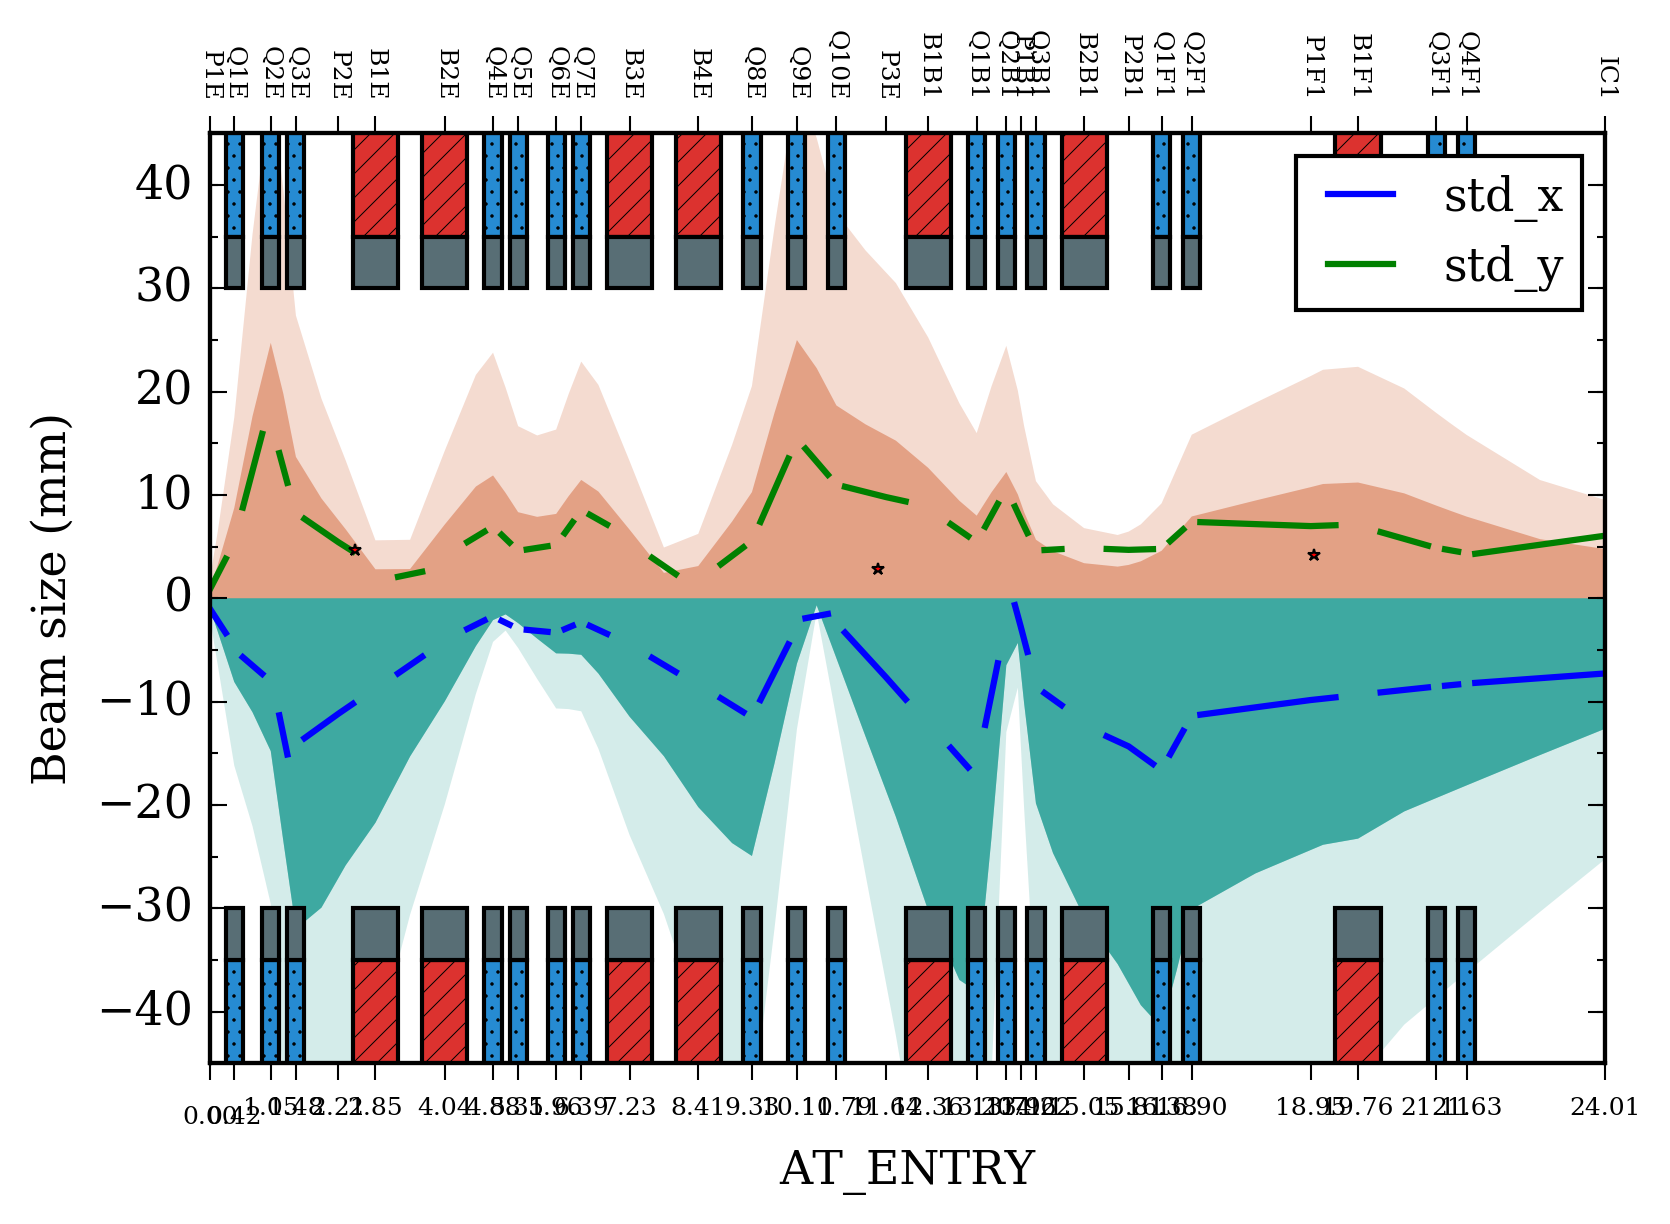

In [167]:
from georges.plotting import *
with plt.style.context('word'):
    fig = plt.figure(1)

    ax1 = fig.add_subplot(111)
    prepare(ax1, bl)
    aperture(ax1, bl)
    twiss(ax1, bl_twiss, context)
    #tracking(ax1, bl, b, plane='X')
    
    bl_track.line.plot('AT_ENTRY', 'std_x', ax=ax1)
    bl_track.line.plot('AT_ENTRY', 'std_y', ax=ax1)
    
    ax1.plot([2.5,11.5, 19], [4.667,2.800, 4.16], '*')

In [141]:
import numpy as np
data = pd.read_csv("/Users/chernals/Ranges.csv", index_col='range')
ranges = pd.Series(pd.to_numeric(data.columns))
data.index
#ranges = data.columns.is_monotonic_decreasing
#ranges

Index(['DEGRADER', 'GROUP3', 'Q1E', 'Q2E', 'Q3E', 'Q47E', 'Q56E', 'Q8E', 'Q9E',
       'Q10E', 'Q1B1', 'Q2B1', 'Q3B1', 'Q1F1', 'Q2F1', 'B1234E', 'B12B1',
       'TRB34E', 'T2E', 'TRB2B1', 'T1F1', 'B1F1', 'Q3F1', 'Q4F1', 'SL1E',
       'SL2E', 'SL3E'],
      dtype='object', name='range')

'D'

In [150]:
data.query("index=='GROUP3'").interpolate()#.values

,32.54,31.5,30.5,29.5,28.5,27.5,26.5,25.5,24.5,23.5,...,15.5,14.5,13.5,12.5,11.5,10.5,9.5,8.5,7.72,4.1
range,,,,,,,,,,,,,,,,,,,,,
GROUP3,1.58967,1.57222,1.55514,1.53777,1.52007,1.50204,1.48364,1.46486,1.44566,1.42602,...,1.24788,1.22206,1.19514,1.16697,1.13737,1.10613,1.07297,1.03751,1.00795,0.837952


In [152]:
import subprocess as sub
p = sub.Popen(["/Users/chernals/bdsim-build/bdsim --file=/Users/chernals/Desktop/bdsim.gmad"],
                      
                      shell=True
                      )

In [154]:
from subprocess import call
call(["/Users/chernals/bdsim-build/bdsim", "--file=/Users/chernals/Desktop/bdsim.gmad"])

1

In [185]:
from georges.plotting import *

survey(ax)

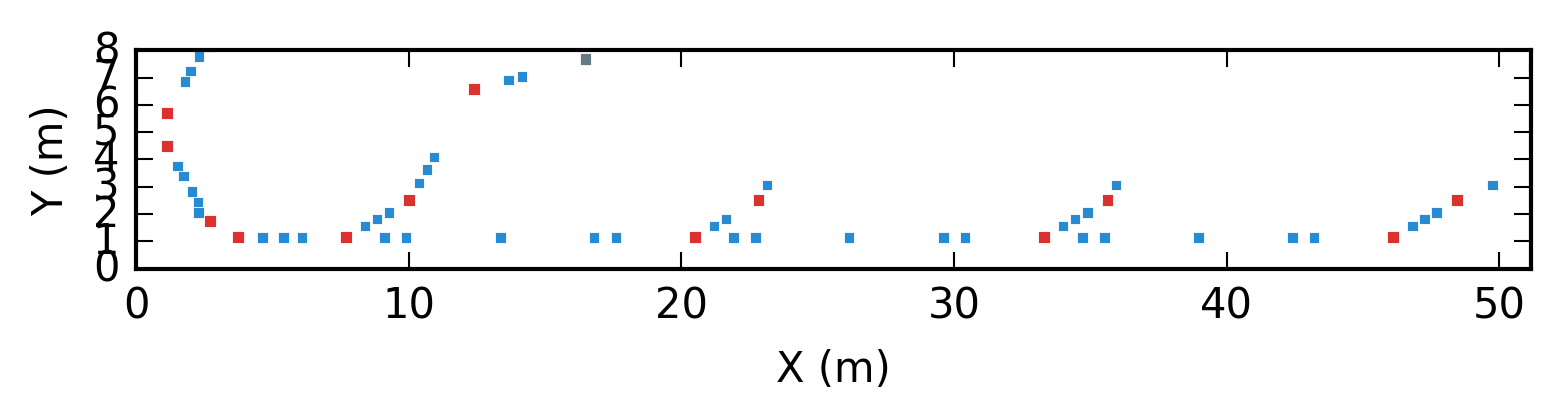

In [203]:
import matplotlib.patches as patches

bl = georges.Beamline(['essen'], survey=True, path=PATH, prefix='generic', elements='elements')


fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_xlim([0, np.max(bl.line['X']) / 1000])
ax1.set_ylim([0, np.max(bl.line['Y']) / 1000])
for index, row in bl.line.iterrows():
    if pd.notnull(row['X']) and pd.notnull(row['Y']):
        #ax1.annotate(index, xy=(row['X'] / 1000, row['Y'] / 1000), xytext=(row['X'] / 1000+0.5, row['Y'] / 1000 + 0.5),
        #    arrowprops=dict(arrowstyle="->",
        #                    facecolor='black', 
        #                    shrinkA = 50,
        #                    shrinkB = 5000,
        #                   ),
        #    size = 3,
        #    horizontalalignment='left',
        #    verticalalignment='bottom',
        #    clip_on=True
        #)
        if row['CLASS'] == 'QUADRUPOLE':
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.20,          # width
                    0.20,          # height
                    facecolor = '#268bd2',
                    edgecolor = '#268bd2'
                )
            )
        elif row['CLASS'] == 'RBEND' or row['CLASS'] == 'SBEND':
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.250,          # width
                    0.250,          # height
                    facecolor = '#dc322f',
                    edgecolor = '#dc322f'
                )
            )
        else:
            ax1.add_patch(
                patches.Rectangle(
                    (row['X'] / 1000, row['Y'] / 1000),   # (x,y)
                    0.250,          # width
                    0.250,          # height
                    facecolor = '#657b83',
                    edgecolor = '#657b83'
                )
            )

In [194]:
fig1.savefig('myfig.svg')


NameError: name 'bl' is not defined

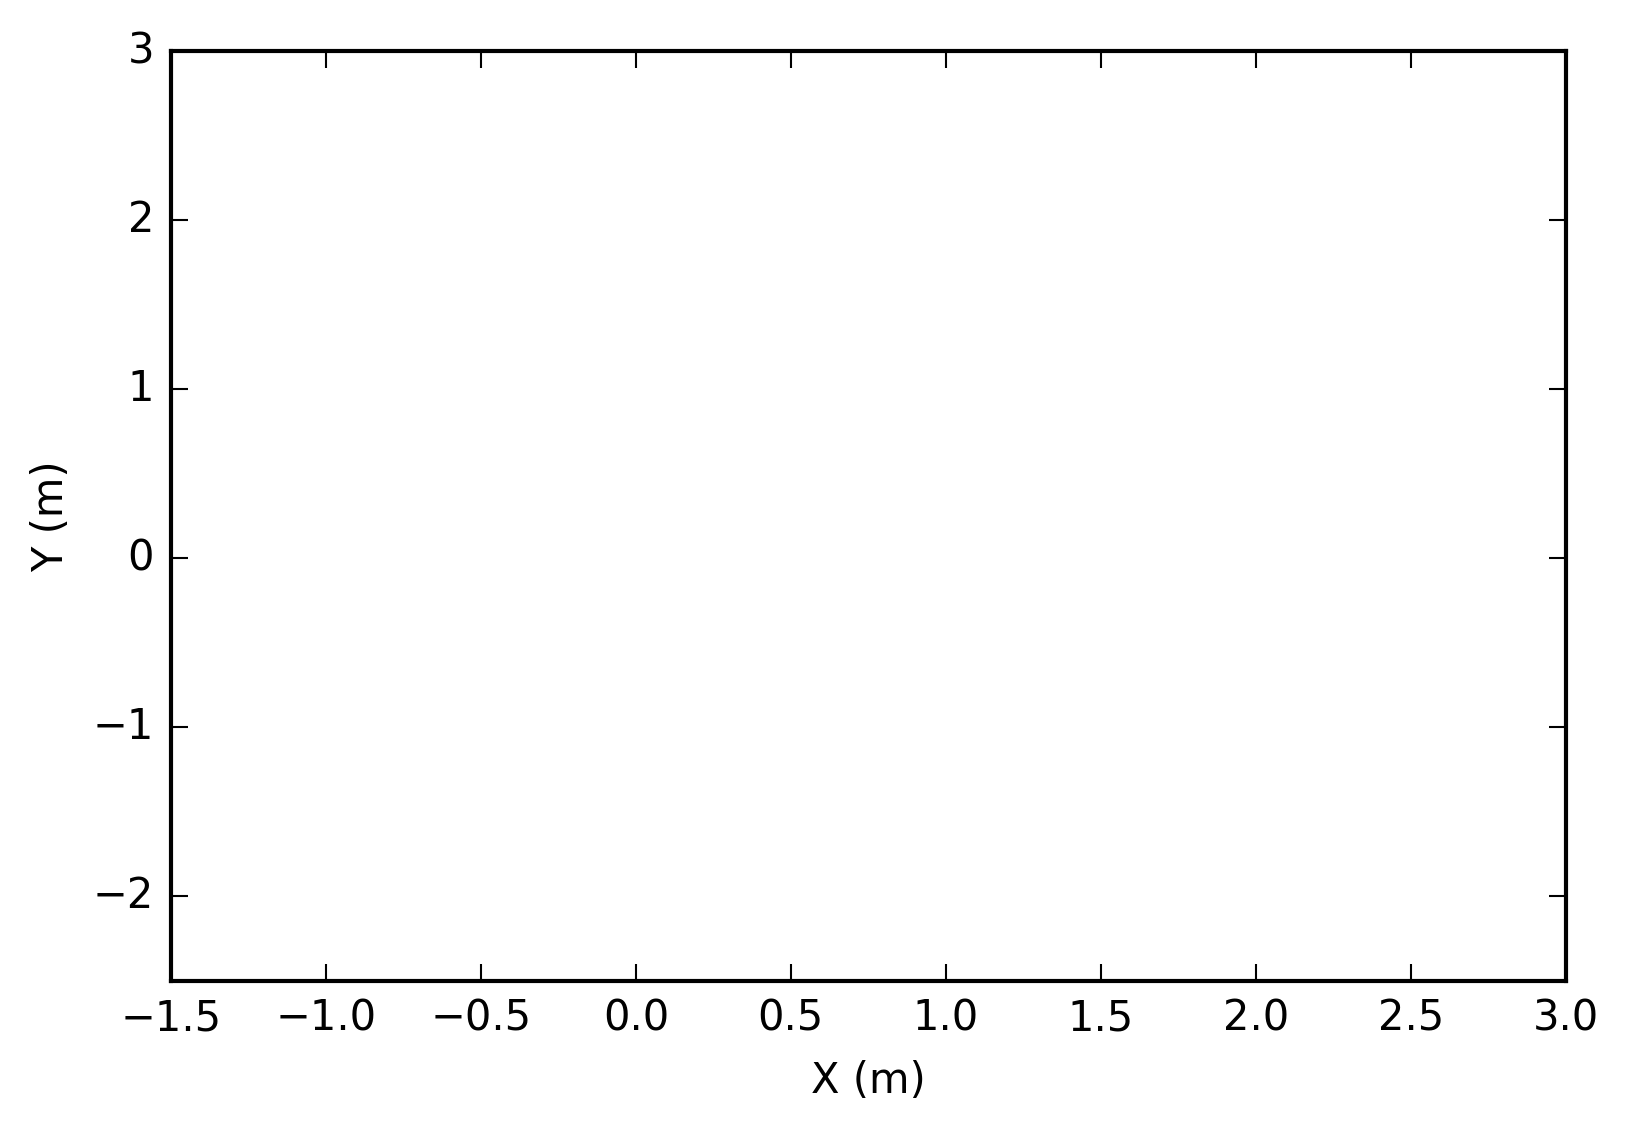

In [17]:
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.path import Path
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)#, aspect='equal')
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_xlim([-1.5, 3])
ax1.set_ylim([-2.5, 3])

tmp = 90
ax1.plot(bl.line['Z'], bl.line['X'], '*')
for index, row in bl.line.iterrows():
    if row['KEYWORD'] == 'SBEND':
        r = row['L']/row['ANGLE']
        theta = -row['THETA']
        angle = row['ANGLE']/np.pi*180.0
        centre = [row['Z']-np.sin(theta)*r,row['X']-np.cos(theta)*r]
        theta1 = min(tmp, tmp-angle)
        theta2 = max(tmp, tmp-angle)
        if angle > 0:
            tmp = theta1
        else:
            tmp = theta2
        w = patches.Wedge(centre, r+0.1, theta1, theta2, width=0.2, facecolor='red', ec=None)
        ax1.add_patch(w)
        print("Theta %f" % theta)
        print("Angle %f = %f" % (angle, angle/180*np.pi))
        print("r %f" % r)
        print("centre %f ; %f" % (centre[0], centre[1]))
        print("theta1 %f" % theta1)
        print("theta2 %f" % theta2)
        print("----")